In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

class Tree_Node:
    def __init__(self, feature = None, threshold = None, left = None, right = None, label = None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.label = label

def Entropy(Y):
    if len(Y):
        p = np.sum(Y)/len(Y)
        if p != 0 and p != 1:
            return -p * math.log2(p) - (1 - p) * math.log2(1 - p)
    return 0

def calculate_ig_ratio( X, Y, feature, threshold):
    # Split data based on threshold
    mask = X[:, feature] >= threshold
    y1 = Y[mask]
    y2 = Y[~mask]

    # Calculate probability
    p = len(y1) / (len(y1)+len(y2))

    # Calculate information gain
    info_gain =  Entropy(Y) - p * Entropy(y1) - (1-p) * Entropy(y2)

    H_S = 0
    # Calculate H(S)
    if p != 0 and p != 1:
        H_S = -p * math.log2(p) - (1-p) * math.log2(1-p)

    # Check for zero split entropy (avoid division by zero)
    if H_S == 0:
        return 0
    else:
        return info_gain / H_S

##Get the best split
def get_best_split(data, labels):
    # Initialize variables
    max_ig_ratio = 0  # Maximum information gain ratio
    best_feature_index = None  # Index of the best feature
    best_threshold = None  # Best threshold value

    num_of_features = data.shape[1]

    # Loop through each feature
    for feature_idx in range(num_of_features):
        unique_thresholds = np.unique(data[:, feature_idx])  # Get unique values for potential thresholds

        # Iterate through potential thresholds
        for threshold in unique_thresholds:
            ig_ratio = calculate_ig_ratio(data, labels, feature_idx, threshold)

            # Update if current split provides higher information gain ratio
            if ig_ratio > max_ig_ratio:
                max_ig_ratio = ig_ratio
                best_feature_index = feature_idx
                best_threshold = threshold

    return best_feature_index, best_threshold, max_ig_ratio


def build_tree(Data, Label):
    best_feature, best_threshold, best_ig_ratio = get_best_split(Data, Label)

    ##the node is empty
    if len(Label) == 0:
      return None

    lable = 0
    ##all splits have zero gain ratio (if the entropy of the split is non-zero)
    if best_ig_ratio == 0:
      if sum(Label) >= len(Label) / 2:
        lable = 1
      return Tree_Node(label = lable)

    left_idx = Data[:, best_feature] >= best_threshold
    right_idx = Data[:, best_feature] < best_threshold
    X_Left = Data[left_idx]
    X_Right = Data[right_idx]
    Y_Left = Label[left_idx]
    Y_Right = Label[right_idx]
    Left_Node = build_tree(X_Left, Y_Left)
    Right_Node = build_tree(X_Right, Y_Right)
    return Tree_Node(feature = best_feature, threshold = best_threshold, left = Left_Node, right = Right_Node)

def predict_label(decision_node, data_point):
    """
    Predict the label for an individual data point using a decision tree.

    Args:
        decision_node (Node): The current node being evaluated.
        data_point (list): The data point to be classified.

    Returns:
        int: The predicted label.
    """
    if decision_node.feature is None:
        return decision_node.label

    if data_point[decision_node.feature] >= decision_node.threshold:
        return predict_label(decision_node.left, data_point)
    else:
        return predict_label(decision_node.right, data_point)

def compute_accuracy(root, X_test, Y_test):
    correct_predictions = 0

    for x, y in zip(X_test, Y_test):
        predicted_label = predict_label(root, x)
        if predicted_label == y:
            correct_predictions += 1

    accuracy = correct_predictions / len(Y_test)
    return accuracy

def read_data_file(file_path):
    Data = []
    Label = []
    with open(file_path, 'r') as file:
        for line in file:
            x1, x2, y = map(float, line.strip().split())
            Data.append([x1, x2])
            Label.append(y)
    return np.array(Data), np.array(Label)

def print_tree(tree, depth=0, feature_names=[]):
    indent = "  " * depth
    if tree.label is not None:
        print(indent + "Predicted Label y =", tree.label)
    else:
        print(indent + f"Is Feature {feature_names[tree.feature]} >= {tree.threshold}?")
        print_tree(tree.left, depth + 1, feature_names)
        print_tree(tree.right, depth + 1, feature_names)


def enni_nodes(tree):
    if tree.feature is None:
        return 1
    return 1 + enni_nodes(tree.left) + enni_nodes(tree.right)


def calculate_error(decision_tree, X_data, y_data):
    """
    Calculates the classification error of a decision tree on a dataset.

    Args:
        decision_tree (object): The decision tree model.
        X_data (array-like): The feature data.
        y_data (array-like): The true labels.

    Returns:
        float: The classification error.
    """
    y_pred = np.array([predict_label(decision_tree, x) for x in X_data])
    accuracy = np.mean(y_pred == y_data)
    error = 1 - accuracy
    return error


##main testing function
def main(train, test):
    X_train, Y_train = read_data_file(train)
    X_test, Y_test = read_data_file(test)
    tree = build_tree(X_train, Y_train)
    return compute_accuracy(tree, X_test, Y_test)


# ***1.3***

In [ ]:
# Define the path to the training data file
training_set_path = "Druns.txt"

# Load training data into NumPy arrays
X_train, y_train = read_data_file(training_set_path)

# Print table header
print(f"{'Feature':<10}{'Threshold':<12}{'Information Gain':<20}{'Information Gain Ratio':<30}")

# Iterate over each feature
num_features = X_train.shape[1]
feature_idx = 0

while feature_idx < num_features:
    # Consider all unique values in the training data as potential split thresholds
    thresholds = np.unique(X_train[:, feature_idx])

    for threshold in thresholds:
        # Split the labels based on the threshold
        y_left = y_train[X_train[:, feature_idx] >= threshold]
        y_right = y_train[X_train[:, feature_idx] < threshold]

        # Calculate probabilities for each split
        p_left = len(y_left) / len(y_train)
        p_right = len(y_right) / len(y_train)

        # Calculate information gain
        info_gain = Entropy(y_train) - p_left * Entropy(y_left) - p_right * Entropy(y_right)

        # Calculate split entropy
        if p_left == 0 or p_left == 1:
            split_entropy = 0
        else:
            split_entropy = -p_left * np.log2(p_left) - p_right * np.log2(p_right)

        # Print information in tabular form
        if split_entropy == 0:
            print(f"{feature_idx:<10}{threshold:<12}{info_gain:<20}{'':<30}")
        else:
            info_gain_ratio = info_gain / split_entropy
            print(f"{feature_idx:<10}{threshold:<12}{'':<20}{info_gain_ratio:<30}")

    feature_idx += 1


Feature   Threshold   Information Gain    Information Gain Ratio        
0         0.0         0.0                                               
0         0.1                             0.10051807676021828           
1         -2.0        0.0                                               
1         -1.0                            0.10051807676021828           
1         0.0                             0.0559537596312636            
1         1.0                             0.00578004220515232           
1         2.0                             0.0011443495172767494         
1         3.0                             0.016411136842102134          
1         4.0                             0.04974906418177849           
1         5.0                             0.11124029586339806           
1         6.0                             0.23609960614360798           
1         7.0                             0.055953759631263686          
1         8.0                             0.4301569

# ***1.4***

In [ ]:
# Define the path to the training data file
training_set_path_p4 = "D3leaves.txt"

# Load training data into NumPy arrays
X_train_p4, y_train_p4 = read_data_file(training_set_path_p4)

# Build the decision tree using the training data
tree_p4 = build_tree(X_train_p4, y_train_p4)

# Assuming you have a list of feature names like ["Feature1", "Feature2"]
feature_names = ["0", "1"]

# Print the decision tree
print_tree(tree_p4, feature_names=feature_names)


Is Feature 0 >= 10.0?
  Predicted Label y = 1
  Is Feature 1 >= 3.0?
    Predicted Label y = 1
    Predicted Label y = 0


# ***1.5***

In [ ]:
# Define the path to the training data file
training_set_path_p5 = "D1.txt"

# Load training data into NumPy arrays
X_train_p5, y_train_p5 = read_data_file(training_set_path_p5)

# Build the decision tree using the training data
tree_p5 = build_tree(X_train_p5, y_train_p5)

# Assuming you have a list of feature names like ["Feature1", "Feature2"]
feature_names = ["0", "1"]

# Print the decision tree
print_tree(tree_p5, feature_names=feature_names)

Is Feature 1 >= 0.201829?
  Predicted Label y = 1
  Predicted Label y = 0


In [ ]:
# Define the path to the training data file
training_set_path_p5 = "D2.txt"

# Load training data into NumPy arrays
X_train_p5, y_train_p5 = read_data_file(training_set_path_p5)

# Build the decision tree using the training data
tree_p5 = build_tree(X_train_p5, y_train_p5)

# Assuming you have a list of feature names like ["Feature1", "Feature2"]
feature_names = ["0", "1"]

# Print the decision tree
print_tree(tree_p5, feature_names=feature_names)

Is Feature 0 >= 0.533076?
  Is Feature 1 >= 0.228007?
    Is Feature 1 >= 0.424906?
      Predicted Label y = 1
      Is Feature 0 >= 0.708127?
        Predicted Label y = 1
        Is Feature 1 >= 0.32625?
          Is Feature 0 >= 0.595471?
            Is Feature 0 >= 0.646007?
              Predicted Label y = 1
              Is Feature 1 >= 0.403494?
                Predicted Label y = 1
                Predicted Label y = 0
            Predicted Label y = 0
          Predicted Label y = 0
    Is Feature 0 >= 0.887224?
      Is Feature 1 >= 0.037708?
        Is Feature 1 >= 0.082895?
          Predicted Label y = 1
          Is Feature 0 >= 0.960783?
            Predicted Label y = 1
            Predicted Label y = 0
        Predicted Label y = 0
      Is Feature 0 >= 0.850316?
        Is Feature 1 >= 0.169053?
          Predicted Label y = 1
          Predicted Label y = 0
        Predicted Label y = 0
  Is Feature 1 >= 0.88635?
    Is Feature 0 >= 0.041245?
      Is Feature 0 >= 

### ***1.6***

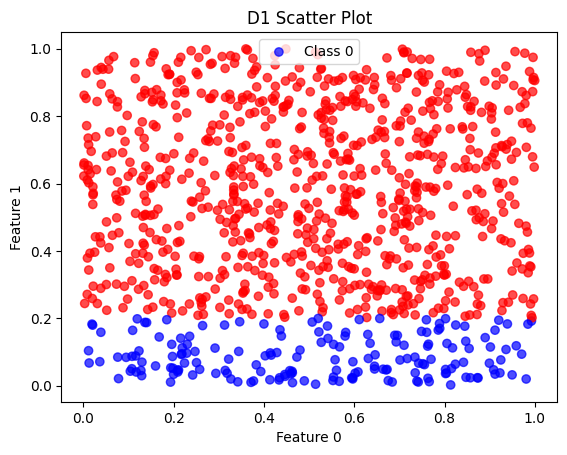

In [ ]:
# Define the path to the training data file
training_set_path_p5 = "D1.txt"

# Load training data into NumPy arrays
X_train_p5, y_train_p5 = read_data_file(training_set_path_p5)

# Define a color map for the classes (assuming binary classification)
colors = ['blue' if label == 0 else 'red' for label in y_train_p5]

# Create the scatter plot with custom colors
plt.scatter(X_train_p5[:, 0], X_train_p5[:, 1], c=colors, alpha=0.7)  # 'alpha' controls transparency
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("D1 Scatter Plot")

# Add a legend (if applicable)
plt.legend(['Class 0', 'Class 1'])

# Show the plot
plt.show()


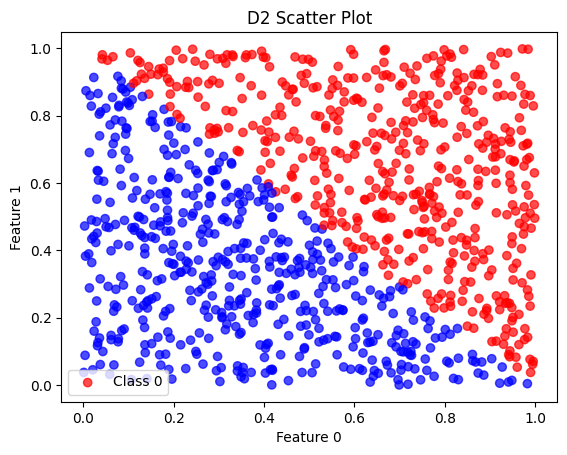

In [ ]:
# Define the path to the training data file
training_set_path_p5 = "D2.txt"

# Load training data into NumPy arrays
X_train_p5, y_train_p5 = read_data_file(training_set_path_p5)

# Define a color map for the classes (assuming binary classification)
colors = ['blue' if label == 0 else 'red' for label in y_train_p5]

# Create the scatter plot with custom colors
plt.scatter(X_train_p5[:, 0], X_train_p5[:, 1], c=colors, alpha=0.7)  # 'alpha' controls transparency
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("D2 Scatter Plot")

# Add a legend (if applicable)
plt.legend(['Class 0', 'Class 1'])

# Show the plot
plt.show()


### ***1.7***

In [ ]:
import random
data = "Dbig.txt"
X7, y7 = read_data_file(data)

# Generate a random permutation of indices
indices = list(range(len(X7)))
random.shuffle(indices)





In [ ]:
# Split at 8192
X_train_p7 = [X7[i] for i in indices[:8192]]
y_train_p7 = [y7[i] for i in indices[:8192]]
X_test_p7 = [X7[i] for i in indices[8192:]]
y_test_p7 = [y7[i] for i in indices[8192:]]

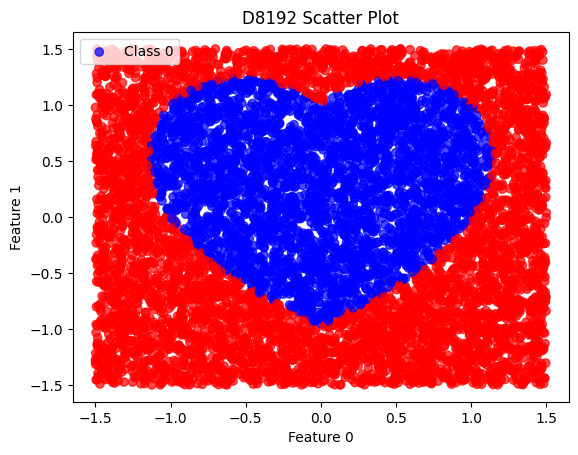

In [ ]:
X_train_p5 = X_train_p7[:8192]
y_train_p5 = y_train_p7[:8192]

# Define a color map for the classes (assuming binary classification)
colors = ['blue' if label == 0 else 'red' for label in y_train_p5]

# Create the scatter plot with custom colors
plt.scatter([x[0] for x in X_train_p5], [x[1] for x in X_train_p5], c=colors, alpha=0.7)  # 'alpha' controls transparency
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("D8192 Scatter Plot")

# Add a legend (if applicable)
plt.legend(['Class 0', 'Class 1'])

# Show the plot
plt.show()


Training size: 32, n: 13, err_n: 0.11172566371681414
Training size: 128, n: 19, err_n: 0.06692477876106195
Training size: 512, n: 63, err_n: 0.04922566371681414
Training size: 2048, n: 129, err_n: 0.03816371681415931
Training size: 8192, n: 263, err_n: 0.020464601769911495


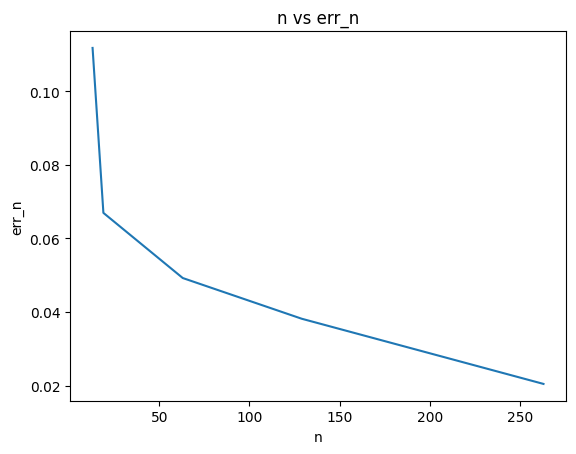

In [ ]:
enni_nodes_total = []
errors = []
for val in np.array([32, 128, 512, 2048, 8192]):
    X_train_p5 = np.array(X_train_p7[:val])
    y_train_p5 = np.array(y_train_p7[:val])
    tree = build_tree(X_train_p5, y_train_p5)
    enni_nodes_total.append( enni_nodes(tree))

    errors.append(calculate_error(tree, X_test_p7, y_test_p7 ) )

    # Print results
    print(f"Training size: {val}, n: {enni_nodes(tree)}, err_n: {calculate_error(tree, X_test_p7, y_test_p7 )}")

# Plotting the number of nodes vs test error
plt.plot(enni_nodes_total, errors )
plt.xlabel("n")
plt.ylabel("err_n")
plt.title("n vs err_n")
plt.show()

Training size: 32, n: 15, err_n: 0.16869469026548672
Training size: 128, n: 27, err_n: 0.103429203539823
Training size: 512, n: 61, err_n: 0.05530973451327434
Training size: 2048, n: 123, err_n: 0.030973451327433628
Training size: 8192, n: 231, err_n: 0.018805309734513276


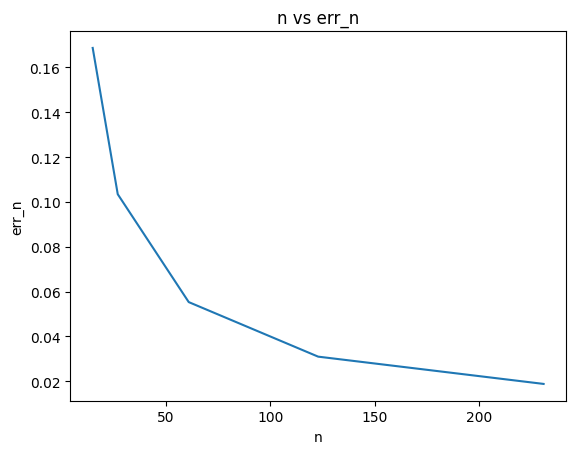

In [ ]:
from sklearn.tree import DecisionTreeClassifier

num_nodes_total = []
errors = []

for val in np.array([32, 128, 512, 2048, 8192]):
    X_train_p5 = np.array(X_train_p7[:val])
    y_train_p5 = np.array(y_train_p7[:val])

    # Instantiate the DecisionTreeClassifier
    tree = DecisionTreeClassifier()
    tree.fit(X_train_p5, y_train_p5)

    num_nodes_total.append(tree.tree_.node_count)

    # Use the model to make predictions
    y_pred = tree.predict(X_test_p7)

    # Calculate test set error
    errors.append(np.mean(y_pred != y_test_p7))

    # Print results
    print(f"Training size: {val}, n: {tree.tree_.node_count}, err_n: {np.mean(y_pred != y_test_p7)}")

# Plotting the number of nodes vs test error
plt.plot(num_nodes_total, errors )
plt.xlabel("n")
plt.ylabel("err_n")
plt.title("n vs err_n")
plt.show()


Log Mean Train Error: 247.27652747913197
Log Mean Test Error: 17.714471547466406


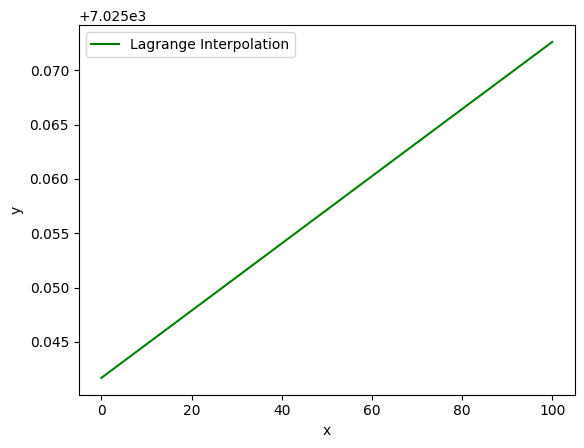

In [32]:
import numpy as np
from scipy.interpolate import lagrange
import matplotlib.pyplot as plt

np.random.seed(1)
# Define the interval [a, b]
a, b = 0, 100

# Define the number of data points
n = 100

# Define the standard deviation of Gaussian noise
epsilon = 1e8  # You can adjust this value

x = np.linspace(a, b, n)

# Add Gaussian noise to x
x = x + np.random.normal(0, epsilon, n)

# Generate y as sin(x)
y = np.sin(x)

# Build the Lagrange interpolation model
lagrange_poly = lagrange(x, y)

# Generate a test set with the same distribution
x_test = np.random.uniform(a, b, 100)
y_test = np.sin(x_test)

# Compute train and test errors
train_error = np.mean((lagrange_poly(x) - y)**2)
test_error = np.mean((lagrange_poly(x_test) - y_test)**2)

# Calculate log mean errors
log_train_error = np.log(train_error)
log_test_error = np.log(test_error)

# Print log mean errors
print(f"Log Mean Train Error: {log_train_error}")
print(f"Log Mean Test Error: {log_test_error}")

# Plot the results
x_values = np.linspace(a, b, 1000)
#plt.plot(x_values, np.sin(x_values), label='sin(x)', color='blue')
#plt.scatter(x, y, color='red', label='Training Data')
plt.plot(x_values, lagrange_poly(x_values), label='Lagrange Interpolation', color='green')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


Log Mean Train Error: 321.4123391449569
Log Mean Test Error: 319.7083526257019


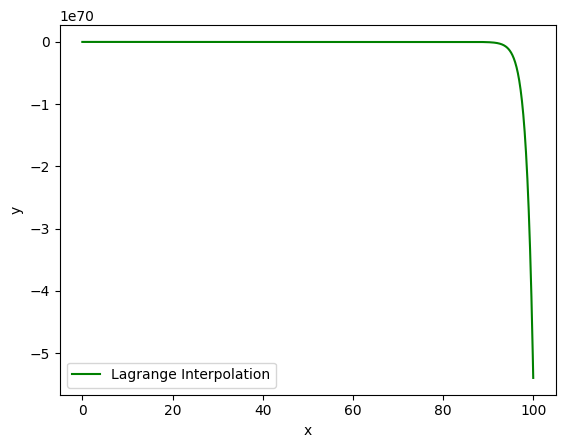

In [33]:
import numpy as np
from scipy.interpolate import lagrange
import matplotlib.pyplot as plt

np.random.seed(1)
# Define the interval [a, b]
a, b = 0, 100

# Define the number of data points
n = 100

# Define the standard deviation of Gaussian noise
epsilon = 0  # You can adjust this value

x = np.linspace(a, b, n)

# Add Gaussian noise to x
x = x + np.random.normal(0, epsilon, n)

# Generate y as sin(x)
y = np.sin(x)

# Build the Lagrange interpolation model
lagrange_poly = lagrange(x, y)

# Generate a test set with the same distribution
x_test = np.random.uniform(a, b, 100)
y_test = np.sin(x_test)

# Compute train and test errors
train_error = np.mean((lagrange_poly(x) - y)**2)
test_error = np.mean((lagrange_poly(x_test) - y_test)**2)

# Calculate log mean errors
log_train_error = np.log(train_error)
log_test_error = np.log(test_error)

# Print log mean errors
print(f"Log Mean Train Error: {log_train_error}")
print(f"Log Mean Test Error: {log_test_error}")

# Plot the results
x_values = np.linspace(a, b, 1000)
#plt.plot(x_values, np.sin(x_values), label='sin(x)', color='blue')
#plt.scatter(x, y, color='red', label='Training Data')
plt.plot(x_values, lagrange_poly(x_values), label='Lagrange Interpolation', color='green')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


Log Mean Train Error: 178.60547049594857
Log Mean Test Error: 143.81409233566976


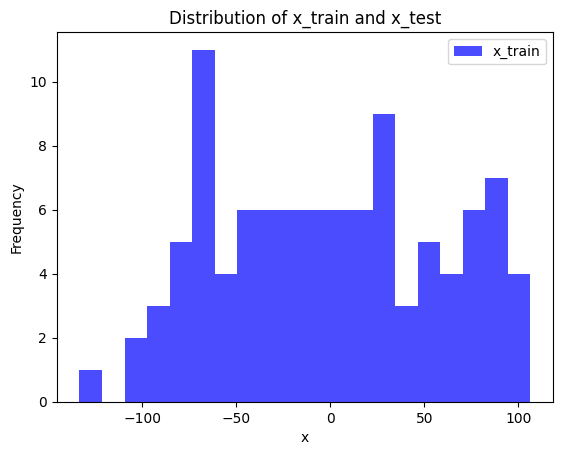

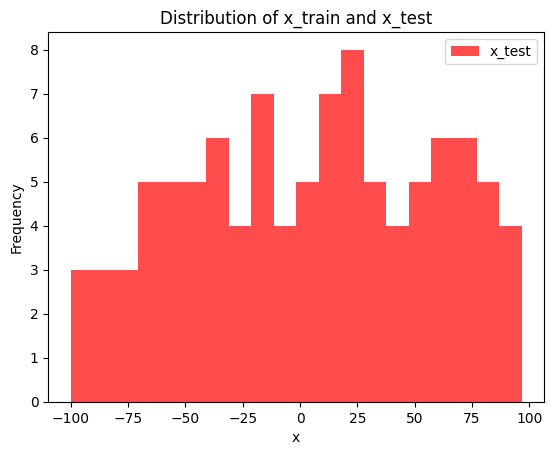

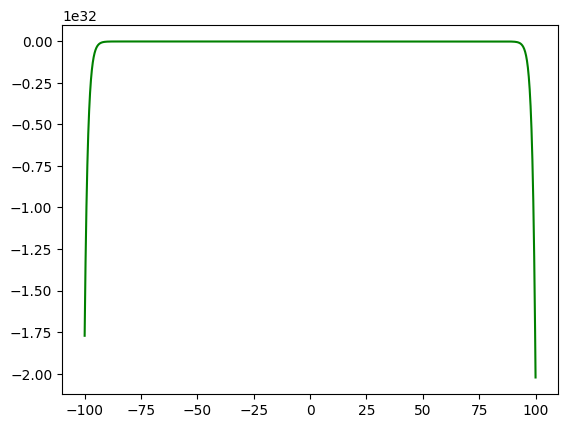

In [59]:
import numpy as np
from scipy.interpolate import lagrange
import matplotlib.pyplot as plt

np.random.seed(1)
# Define the interval [a, b]
a, b = -100, 100

# Define the number of data points
n = 100

# Define the standard deviation of Gaussian noise
epsilon = 20  # You can adjust this value

x = np.random.uniform(a, b, 100)

# Add Gaussian noise to x
x = x + np.random.normal(0, epsilon, n)

# Generate y as sin(x)
y = np.sin(x)

# Build the Lagrange interpolation model
lagrange_poly = lagrange(x, y)

# Generate a test set with the same distribution
x_test = np.random.uniform(a, b, 100)
y_test = np.sin(x_test)

# Compute train and test errors
train_error = np.mean((lagrange_poly(x) - y)**2)
test_error = np.mean((lagrange_poly(x_test) - y_test)**2)

# Calculate log mean errors
log_train_error = np.log(train_error)
log_test_error = np.log(test_error)

# Print log mean errors
print(f"Log Mean Train Error: {log_train_error}")
print(f"Log Mean Test Error: {log_test_error}")

# Plot histograms of x_train and x_test
plt.figure()
plt.hist(x, bins=20, color='blue', alpha=0.7, label='x_train')
#plt.hist(x_test, bins=20, color='red', alpha=0.7, label='x_test')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of x_train and x_test')

plt.show()
# Plot histograms of x_train and x_test
plt.figure()
#plt.hist(x, bins=20, color='blue', alpha=0.7, label='x_train')
plt.hist(x_test, bins=20, color='red', alpha=0.7, label='x_test')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of x_train and x_test')

plt.show()

# Plot the results
x_values = np.linspace(a, b, 1000)

# Plot the Lagrange Interpolation
plt.plot(x_values, lagrange_poly(x_values), label='Lagrange Interpolation', color='green')

Log Mean Train Error: 162.36357116902286
Log Mean Test Error: 161.91929421725322


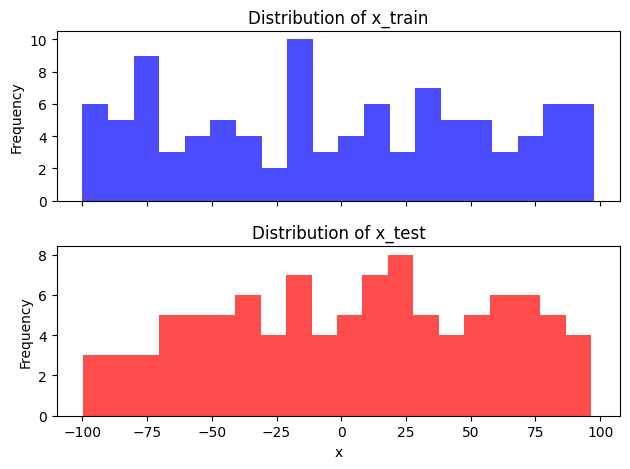

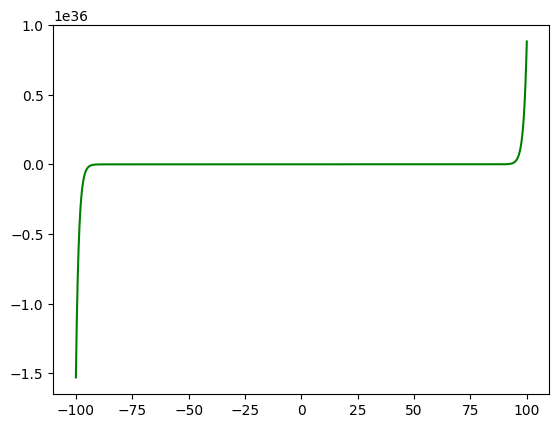

In [60]:
import numpy as np
from scipy.interpolate import lagrange
import matplotlib.pyplot as plt

np.random.seed(1)
# Define the interval [a, b]
a, b = -100, 100

# Define the number of data points
n = 100

# Define the standard deviation of Gaussian noise
epsilon = 0  # You can adjust this value

x = np.random.uniform(a, b, 100)

# Add Gaussian noise to x
x = x + np.random.normal(0, epsilon, n)

# Generate y as sin(x)
y = np.sin(x)

# Build the Lagrange interpolation model
lagrange_poly = lagrange(x, y)

# Generate a test set with the same distribution
x_test = np.random.uniform(a, b, 100)
y_test = np.sin(x_test)

# Compute train and test errors
train_error = np.mean((lagrange_poly(x) - y)**2)
test_error = np.mean((lagrange_poly(x_test) - y_test)**2)

# Calculate log mean errors
log_train_error = np.log(train_error)
log_test_error = np.log(test_error)

# Print log mean errors
print(f"Log Mean Train Error: {log_train_error}")
print(f"Log Mean Test Error: {log_test_error}")

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot x_train in the first subplot
ax1.hist(x, bins=20, color='blue', alpha=0.7)
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of x_train')

# Plot x_test in the second subplot
ax2.hist(x_test, bins=20, color='red', alpha=0.7)
ax2.set_xlabel('x')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of x_test')

plt.tight_layout()  # Adjust spacing between subplots

plt.show()

# Plot the results
x_values = np.linspace(a, b, 1000)

# Plot the Lagrange Interpolation
plt.plot(x_values, lagrange_poly(x_values), label='Lagrange Interpolation', color='green')